In [ ]:
import pandas as pd
from pathlib import Path

CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv")

df = pd.read_csv(CSV_PATH)
df['timestamp_parsed'] = pd.to_datetime(df['timestamp'], utc=True)

total_rows = len(df)

print("Total rows:", total_rows)

# SCENARIO A/B/C INDEX RANGES
A_end = 226_800
B_end = 320_400
C_start_idx = 320_400          # 0-based
C_end_idx   = 475_200 - 1      # 0-based inclusive end

print("\nScenario A rows: 1 → 226800")
print("Scenario B rows: 226801 → 320400")
print("Scenario C rows: 320401 → 475200\n")

print("Using 0-based indices:")
print("Scenario C index start:", C_start_idx)
print("Scenario C index end  :", C_end_idx)

# Derive timestamps for C-window
C_start_ts = df.loc[C_start_idx, 'timestamp_parsed']
C_end_ts   = C_start_ts + pd.Timedelta(days=7)

print("\nScenario C time window:")
print("C_start_ts:", C_start_ts)
print("C_end_ts  :", C_end_ts)

# Mask for timestamps inside window
mask_C = (df['timestamp_parsed'] >= C_start_ts) & (df['timestamp_parsed'] < C_end_ts)

print("\nRows inside the timestamp window:", mask_C.sum())
print("Rows inside index window        :", (df.index >= C_start_idx) & (df.index <= C_end_idx).sum())

# Combined strict mask: must be within BOTH index + timestamp range
mask_C_strict = mask_C & (df.index.to_series().between(C_start_idx, C_end_idx))
print("Final strict Scenario-C row count:", mask_C_strict.sum())


In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Build time axis for full 7-day C-window
C_window_secs = int((C_end_ts - C_start_ts).total_seconds())
print("Scenario C window seconds:", C_window_secs)

# Baseline near-healthy, small upward drift
base_start = 0.25
base_end   = 0.40

trend = np.linspace(base_start, base_end, C_window_secs)

# slight smoothing for realism
trend = gaussian_filter1d(trend, sigma=1800)

# clamp
trend = np.clip(trend, 0.0, 1.0)

print("Trend sample:", trend[:5], "...", trend[-5:])


In [ ]:
rng = np.random.default_rng(42)

BURSTS_PER_DAY = 14               # tuneable
NUM_BURSTS = BURSTS_PER_DAY * 7

burst_starts = rng.integers(0, C_window_secs, size=NUM_BURSTS)
burst_dur    = rng.integers(20, 240, size=NUM_BURSTS)   # 20–120 seconds
burst_amp    = rng.uniform(0.25, 0.45, size=NUM_BURSTS) # add on top of trend

bursts = []
for s, d, a in zip(burst_starts, burst_dur, burst_amp):
    e = min(s + d, C_window_secs - 1)
    bursts.append((s, e, a))

print("Generated bursts:", len(bursts))


In [ ]:
# Low-frequency noise
lf = gaussian_filter1d(rng.normal(0, 1, C_window_secs), sigma=3600)
lf = lf / lf.std() * 0.01   # amplitude

# High-frequency noise
hf = rng.normal(0, 0.025, C_window_secs)

noise = lf + hf
noise = noise - noise.mean()

# Add bursts
noise_burst = noise.copy()
for s, e, amp in bursts:
    dur = e - s + 1
    rel = np.linspace(0,1,dur)
    envelope = 1 - np.abs(2*rel - 1)   # triangular
    noise_burst[s:e+1] += envelope * amp

# Final clamp
final_series = np.clip(trend + noise_burst, 0.0, 1.0)

print("Final series sample:", final_series[:5], "...", final_series[-5:])


In [ ]:
# compute seconds offset for each strict Scenario-C row
offset_secs = ((df.loc[mask_C_strict, 'timestamp_parsed'] - C_start_ts)
                 .dt.total_seconds()
                 .astype(int))

values_C = final_series[offset_secs.values]

# Apply small per-row jitter
values_C = np.clip(values_C + rng.normal(0,0.005,len(values_C)) + 0.02, 0, 1)

# Update df
df.loc[mask_C_strict, 'composite_score'] = values_C
df.loc[mask_C_strict, 'composite_health'] = 1 - values_C

print("Updated Scenario-C rows:", mask_C_strict.sum())


In [ ]:
import os

tmp = CSV_PATH.with_suffix(".tmp")
df.to_csv(tmp, index=False)
os.replace(tmp, CSV_PATH)

print("CSV updated successfully:", CSV_PATH)


In [ ]:
# Corrected Cell 15: diagnostics and compressed timeline plot for A (first 12 days) + B + C
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

CSV_PATH = r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv"

# Re-load timestamps+composite for plotting in a safe way
use_cols = ["timestamp", "composite_score"]
df_plot = pd.read_csv(CSV_PATH, usecols=use_cols)
df_plot = df_plot.dropna(subset=["timestamp", "composite_score"]).reset_index(drop=True)
df_plot["timestamp"] = pd.to_datetime(df_plot["timestamp"], utc=True)
df_plot = df_plot.sort_values("timestamp").reset_index(drop=True)

# Determine start_date (first day) and B and C windows using known indices and timestamps
start_ts = df_plot["timestamp"].min()
start_date = start_ts.normalize()
first12_end = start_date + pd.Timedelta(days=12)

# Attempt to reuse previously computed B_start/B_end/C_start/C_end if present in notebook memory,
# else compute from index-based canonical boundaries we agreed on
try:
    B_start = t0   # earlier scenario B start (if available)
    B_end   = t_end
except NameError:
    # derive B_start as first timestamp after first12_end
    B_start = df_plot[df_plot["timestamp"] >= first12_end]["timestamp"].min()
    B_end   = B_start + pd.Timedelta(days=7)

# canonical C index window: rows 320401..475200 (1-based)
# map that to timestamps defensively
# (we will compute C_start based on row index 320401 -> 0-based 320400)
total_rows = len(df_plot)
idx_c_start_0 = 320400
idx_c_end_0 = 475200 - 1

if idx_c_start_0 < total_rows:
    C_start = df_plot.loc[idx_c_start_0, "timestamp"]
else:
    raise IndexError(f"CSV has only {total_rows} rows but expected index {idx_c_start_0} for C start.")

C_end = C_start + pd.Timedelta(days=7)

print("Plot windows:\n A: {} -> {}\n B: {} -> {}\n C: {} -> {}".format(start_date, first12_end, B_start, B_end, C_start, C_end))

# Select combined window = first12_start .. C_end
combined_start = start_date
combined_end = C_end
mask_combined = (df_plot["timestamp"] >= combined_start) & (df_plot["timestamp"] < combined_end)
df_sel = df_plot.loc[mask_combined].copy().reset_index(drop=True)
if df_sel.empty:
    raise ValueError("No rows found in the combined plotting window. Check indices/timestamps.")

print("Rows in combined plotting window:", len(df_sel))

# compress timeline by removing gaps > 30 minutes
GAP_MINUTES = 30
gap_thresh = pd.Timedelta(minutes=GAP_MINUTES)
ts = df_sel["timestamp"]
diffs = ts.diff().fillna(pd.Timedelta(seconds=0))
is_segment_start = (diffs > gap_thresh)
segment_id = is_segment_start.cumsum()

prev_end = ts.iloc[0]
shifts = pd.Series(pd.Timedelta(0), index=df_sel.index)
cumulative_shift = pd.Timedelta(0)
for seg_idx, (_, grp) in enumerate(df_sel.groupby(segment_id)):
    seg_start = grp["timestamp"].iloc[0]
    seg_end = grp["timestamp"].iloc[-1]
    if seg_idx == 0:
        cumulative_shift = pd.Timedelta(0)
    else:
        gap = seg_start - prev_end
        remove = gap
        cumulative_shift += remove
    shifts.loc[grp.index] = cumulative_shift
    prev_end = seg_end

df_sel["shifted_ts"] = df_sel["timestamp"] - shifts.values

# compute 1-minute resample + 1-hour rolling mean
df_shift = df_sel.set_index("shifted_ts").sort_index()
resampled = df_shift["composite_score"].resample("1T").mean().interpolate(limit_direction='both')
hr_line = resampled.rolling(window=60, min_periods=1).mean()

# plot
plt.figure(figsize=(16,5))
plt.scatter(df_shift.index, df_shift["composite_score"], s=6, alpha=0.18, color="tab:blue", label="composite_score (points)")
plt.plot(hr_line.index, hr_line.values, linewidth=2.0, color="#D62728", label="1-hour rolling mean")

# compute shifted boundaries for B and C windows using timestamp-based selection (robust)
def shifted_span_for_window(window_start, window_end, df_sel):
    rows = df_sel[(df_sel["timestamp"] >= window_start) & (df_sel["timestamp"] < window_end)]
    if rows.empty:
        return None, None
    return rows["shifted_ts"].iloc[0], rows["shifted_ts"].iloc[-1]

b_start_shifted, b_end_shifted = shifted_span_for_window(B_start, B_end, df_sel)
c_start_shifted, c_end_shifted = shifted_span_for_window(C_start, C_end, df_sel)

if b_start_shifted is not None:
    plt.axvspan(b_start_shifted, b_end_shifted, color="gray", alpha=0.12, label="Scenario B window")
if c_start_shifted is not None:
    plt.axvspan(c_start_shifted, c_end_shifted, color="orange", alpha=0.12, label="Scenario C window")

# annotate top 3 peaks in C-window (if any)
if c_start_shifted is not None:
    rows_c = df_sel[(df_sel["timestamp"] >= C_start) & (df_sel["timestamp"] < C_end)]
    if not rows_c.empty:
        top3 = rows_c.nlargest(3, "composite_score")
        for _, r in top3.iterrows():
            shifted = r["shifted_ts"]
            val = r["composite_score"]
            plt.plot(shifted, val, marker="o", color="black")
            plt.annotate(f"{val:.2f}\n{r['timestamp'].strftime('%Y-%m-%d %H:%M')}",
                         xy=(shifted, val), xytext=(6,6), textcoords="offset points", fontsize=8,
                         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8))

plt.title("Composite Score — A (first 12 days) + B (7d) + C (7d) — compressed timeline")
plt.xlabel("Compressed operating time (gaps >30min removed)")
plt.ylabel("Composite Score")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# print diagnostics for C-window
df_c = df_sel[(df_sel["timestamp"] >= C_start) & (df_sel["timestamp"] < C_end)].copy()
print("\nC-window per-day composite summary (if any):")
if not df_c.empty:
    df_c["date_only"] = df_c["timestamp"].dt.date
    perday = df_c.groupby("date_only")["composite_score"].agg(['count','mean','std','min','max']).reset_index()
    print(perday.to_string(index=False))
else:
    print("No rows in C-window for diagnostics.")

# detect anomaly segments (threshold 0.6)
if not df_c.empty:
    thr = 0.6
    df_c["is_anom"] = (df_c["composite_score"] > thr).astype(int)
    df_c["seg_id"] = (df_c["is_anom"] != df_c["is_anom"].shift(1)).cumsum()
    segs = []
    for seg_id, grp in df_c.groupby("seg_id"):
        if grp["is_anom"].iloc[0] == 1:
            start = grp["timestamp"].iloc[0]; end = grp["timestamp"].iloc[-1]
            segs.append({"seg_id":int(seg_id), "start":str(start), "end":str(end), "dur_s":int((end-start).total_seconds()), "n":len(grp)})
    segs_sorted = sorted(segs, key=lambda x: x["dur_s"], reverse=True)
    print(f"\nDetected {len(segs_sorted)} anomaly segments in C-window (threshold>{thr}). Top 10:")
    for s in segs_sorted[:10]:
        print(f"  seg {s['seg_id']}: start={s['start']} end={s['end']} dur_s={s['dur_s']} n={s['n']}")
else:
    print("No anomaly segments in C-window.")


In [ ]:
# Cell 17: build a per-row gradual rising 7-day trend for Scenario D (per-selected-row, not per-second)
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from pathlib import Path

CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv")

# Load full CSV and timestamps (defensive)
df = pd.read_csv(CSV_PATH, low_memory=False)
df["timestamp_parsed"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")

# Recompute D indices/timestamps (defensive, reuse your canonical numbers)
D_start_1 = 475_201
D_end_1   = 604_800
D_start_idx0 = D_start_1 - 1
D_end_idx0   = D_end_1 - 1

if D_end_idx0 >= len(df):
    raise IndexError(f"CSV has {len(df)} rows but expected D_end index {D_end_idx0} to exist.")

D_start_ts = df.loc[D_start_idx0, "timestamp_parsed"]
D_end_ts   = D_start_ts + pd.Timedelta(days=7)

# strict mask (index + time)
mask_index = df.index.to_series().between(D_start_idx0, D_end_idx0)
mask_time = (df["timestamp_parsed"] >= D_start_ts) & (df["timestamp_parsed"] < D_end_ts)
mask_strict = mask_time & mask_index

n_to_update = int(mask_strict.sum())
print(f"[Cell17] Rows in strict Scenario D slice: {n_to_update:,}")

if n_to_update == 0:
    raise RuntimeError("No rows selected for Scenario D update. Aborting to avoid accidental edits.")

# Trend parameters (same baseline semantics you had)
start_val = 0.40
end_val   = 0.52

# Build a baseline trend sized to the number of rows to update
row_trend = np.linspace(start_val, end_val, n_to_update)

# Optional smoothing on the row trend (small fraction of total rows)
smooth_fraction = 0.01  # 1% of rows; adjust if you want more/less smoothing
sigma_rows = max(1, int(n_to_update * smooth_fraction))
row_trend = gaussian_filter1d(row_trend, sigma=sigma_rows)

print(f"[Cell17] Built row_trend (n={n_to_update}), smoothing sigma_rows={sigma_rows}.")
print("[Cell17] row_trend sample (first 5 / last 5):", row_trend[:5], "...", row_trend[-5:])


In [ ]:
# Cell 18: generate LF + HF noise and a couple of tiny bursts (per-row)
import numpy as np

# RNG (kept seed for reproducibility)
rng = np.random.default_rng(20251123)

# Noise parameters (translated to "rows" domain)
lf_amp = 0.01                # low frequency amplitude (relative)
hf_base = 0.02               # high-frequency jitter std
row_jitter_sd = 0.003        # tiny per-row jitter

# Interpret the previous lf_sigma_seconds as a fraction of the 7-day window, but operate in rows
# If you used lf_sigma_seconds = 7200 seconds (2 hours) previously, compute equivalent rows smoothing
lf_sigma_seconds = 7200
window_sec = int((D_end_ts - D_start_ts).total_seconds())
lf_sigma_rows = max(1, int((lf_sigma_seconds / window_sec) * n_to_update))

# Low-frequency noise (filtered white noise) on rows
lf_white = rng.normal(0.0, 1.0, n_to_update)
lf_noise = gaussian_filter1d(lf_white, sigma=lf_sigma_rows)
lf_noise = lf_noise / (np.std(lf_noise) + 1e-12) * lf_amp

# High-frequency noise on rows
hf_noise = rng.normal(0.0, hf_base, n_to_update)

combined_noise = lf_noise + hf_noise
combined_noise = combined_noise - np.mean(combined_noise)  # zero-mean

# Very few small bursts to add realism (0-2 across 7 days) but placed in row-space
num_bursts = int(rng.integers(0, 3))  # 0,1,2
bursts = []
for _ in range(num_bursts):
    # choose a safe start so dur fits in n_to_update
    if n_to_update <= 120:
        s = 0
        dur = max(1, int(n_to_update * 0.1))
    else:
        s = int(rng.integers(0, n_to_update - 60))
        dur = int(rng.integers(20, min(60, n_to_update - s)))
    e = min(n_to_update - 1, s + dur)
    amp = float(rng.uniform(0.03, 0.12))
    bursts.append((s, e, amp))
    rel = np.linspace(0, 1, e - s + 1)
    env = 1 - np.abs(2 * rel - 1.0)  # triangular envelope
    combined_noise[s:e+1] += env * amp

print(f"[Cell18] LF sigma rows: {lf_sigma_rows}, LF std: {float(np.std(lf_noise)):.6f}, HF std: {float(np.std(hf_noise)):.6f}, num_bursts: {num_bursts}")
print("[Cell18] Example bursts (row-start, row-end, amp):", bursts)


In [ ]:
# Cell 19: compose final series and assign to strict Scenario D rows (no file write; safe assignment)
import numpy as np
import pandas as pd

# final values per-row: baseline + combined_noise + tiny per-row jitter
final_vals = row_trend + combined_noise + rng.normal(0.0, row_jitter_sd, n_to_update) 
final_vals = np.clip(final_vals, 0.0, 1.0)

# Defensive checks
if len(final_vals) != n_to_update:
    raise RuntimeError("Length mismatch between generated final_vals and n_to_update.")

# Assign back to dataframe preserving original index order
strict_idx = df.loc[mask_strict].index
if len(strict_idx) != n_to_update:
    # This would be surprising, but handle gracefully
    raise RuntimeError("Index count mismatch when mapping values back to dataframe.")

df.loc[strict_idx, "composite_score"] = final_vals
df.loc[strict_idx, "composite_health"] = 1.0 - final_vals

# Recompute labels/severity for strict rows
def label_and_sev(v):
    if v > 0.6:
        return "anomaly", 2
    elif v > 0.4:
        return "suspicious", 1
    else:
        return "normal", 0

labs = [label_and_sev(v) for v in final_vals]
lab_col, sev_col = zip(*labs) if labs else ([], [])
df.loc[strict_idx, "anomaly_label"] = lab_col
df.loc[strict_idx, "anomaly_severity"] = sev_col

# Quick diagnostics: summary stats on assigned block
assigned_min = float(np.min(final_vals))
assigned_max = float(np.max(final_vals))
assigned_mean = float(np.mean(final_vals))
assigned_std = float(np.std(final_vals))
print(f"[Cell19] Assigned values summary — min: {assigned_min:.6f}, max: {assigned_max:.6f}, mean: {assigned_mean:.6f}, std: {assigned_std:.6f}")

# Sanity: how many rows hit the envelope edges (start / end) if you care
edge_hits_start = int((final_vals <= (start_val + 1e-9)).sum())
edge_hits_end = int((final_vals >= (end_val - 1e-9)).sum())
print(f"[Cell19] Edge hits: <=start_val: {edge_hits_start}, >=end_val: {edge_hits_end}")

# Note: you already have Cell 20 that writes the CSV atomically.
# If you want a tiny visual check (requires matplotlib), you can uncomment below:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,3))
# plt.plot(final_vals[:1000], label='assigned (first 1000 rows)')
# plt.title('Assigned composite_score (sample)')
# plt.legend()
# plt.show()


In [ ]:
# Cell 20: atomic write back to CSV (safe replace)
import os

tmp = CSV_PATH.with_suffix(".tmp")
# drop helper column if present
if "timestamp_parsed" in df.columns:
    df_to_write = df.drop(columns=["timestamp_parsed"])
else:
    df_to_write = df
df_to_write.to_csv(tmp, index=False)
os.replace(tmp, CSV_PATH)
print("CSV updated in place:", CSV_PATH)


In [ ]:
# Cell 21: Diagnostics + compressed timeline plot for A (first 12d) + B + C + D (showing D gradual rise)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# reload minimal columns
use_cols = ["timestamp", "composite_score"]
df_plot = pd.read_csv(CSV_PATH, usecols=use_cols)
df_plot = df_plot.dropna(subset=["timestamp", "composite_score"]).reset_index(drop=True)
df_plot["timestamp"] = pd.to_datetime(df_plot["timestamp"], utc=True)
df_plot = df_plot.sort_values("timestamp").reset_index(drop=True)

# define combined window (A start .. D end)
start_date = df_plot["timestamp"].min().normalize()
A_first12_end = start_date + pd.Timedelta(days=12)
# B_start/B_end infer (safe)
B_start = df_plot[df_plot["timestamp"] >= A_first12_end]["timestamp"].min()
B_end = B_start + pd.Timedelta(days=7)
# C_start we derive from canonical index 320400 (0-based)
C_start = df_plot.loc[320400, "timestamp"]
C_end = C_start + pd.Timedelta(days=7)
# D_start from canonical index (we computed earlier)
D_start = df_plot.loc[D_start_idx0, "timestamp"]
D_end = D_start + pd.Timedelta(days=7)

print("Window dates: A start:", start_date, "-> D end:", D_end)

# Select plotting window: from A start to D end (inclusive)
mask_window = (df_plot["timestamp"] >= start_date) & (df_plot["timestamp"] < D_end)
df_sel = df_plot.loc[mask_window].copy().reset_index(drop=True)
print("Rows plotted:", len(df_sel))

# compress timeline by removing gaps > 30 minutes
GAP_MINUTES = 30
gap_thresh = pd.Timedelta(minutes=GAP_MINUTES)
ts = df_sel["timestamp"]
diffs = ts.diff().fillna(pd.Timedelta(seconds=0))
is_segment_start = (diffs > gap_thresh)
segment_id = is_segment_start.cumsum()

prev_end = ts.iloc[0]
shifts = pd.Series(pd.Timedelta(0), index=df_sel.index)
cumulative_shift = pd.Timedelta(0)
for seg_idx, (_, grp) in enumerate(df_sel.groupby(segment_id)):
    seg_start = grp["timestamp"].iloc[0]
    seg_end = grp["timestamp"].iloc[-1]
    if seg_idx == 0:
        cumulative_shift = pd.Timedelta(0)
    else:
        gap = seg_start - prev_end
        cumulative_shift += gap
    shifts.loc[grp.index] = cumulative_shift
    prev_end = seg_end

df_sel["shifted_ts"] = df_sel["timestamp"] - shifts.values

# compute 1-minute resample and 1-hour rolling mean
df_shift = df_sel.set_index("shifted_ts").sort_index()
resampled = df_shift["composite_score"].resample("0.1T").mean().interpolate(limit_direction='both')
hr_line = resampled.rolling(window=60, min_periods=1).mean()

# plot
plt.figure(figsize=(18,6))
plt.scatter(df_shift.index, df_shift["composite_score"], s=5, alpha=0.20, label="composite_score (points)")
plt.plot(hr_line.index, hr_line.values, linewidth=2.2, color="#D62728", label="1-hour rolling mean")

# compute shifted spans for B, C, D for shading
def shifted_bounds(win_start, win_end, df_sel):
    rows = df_sel[(df_sel["timestamp"] >= win_start) & (df_sel["timestamp"] < win_end)]
    if rows.empty:
        return None, None
    return rows["shifted_ts"].iloc[0], rows["shifted_ts"].iloc[-1]

b_s, b_e = shifted_bounds(B_start, B_end, df_sel)
c_s, c_e = shifted_bounds(C_start, C_end, df_sel)
d_s, d_e = shifted_bounds(D_start, D_end, df_sel)

if b_s is not None:
    plt.axvspan(b_s, b_e, color="gray", alpha=0.12, label="Scenario B")
if c_s is not None:
    plt.axvspan(c_s, c_e, color="orange", alpha=0.12, label="Scenario C")
if d_s is not None:
    plt.axvspan(d_s, d_e, color="green", alpha=0.12, label="Scenario D (gradual)")

plt.title("Composite Score — A + B + C + D (compressed timeline). Scenario D shows gradual upward trend.")
plt.xlabel("Compressed operating time (gaps removed)")
plt.ylabel("Composite Score")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# Diagnostics for D-window
df_d = df_sel[(df_sel["timestamp"] >= D_start) & (df_sel["timestamp"] < D_end)].copy()
if not df_d.empty:
    df_d["date_only"] = df_d["timestamp"].dt.date
    perday = df_d.groupby("date_only")["composite_score"].agg(['count','mean','std','min','max']).reset_index()
    print("\nPer-day composite summary for Scenario D:")
    print(perday.to_string(index=False))
    # Detect anomaly segments (threshold 0.6)
    thr = 0.6
    df_d["is_anom"] = (df_d["composite_score"] > thr).astype(int)
    df_d["seg_id"] = (df_d["is_anom"] != df_d["is_anom"].shift(1)).cumsum()
    segs = []
    for seg_id, grp in df_d.groupby("seg_id"):
        if grp["is_anom"].iloc[0] == 1:
            start = grp["timestamp"].iloc[0]; end = grp["timestamp"].iloc[-1]
            segs.append({"seg_id":int(seg_id), "start":str(start), "end":str(end), "dur_s":int((end-start).total_seconds()), "n":len(grp)})
    segs_sorted = sorted(segs, key=lambda x: x["dur_s"], reverse=True)
    print(f"\nDetected {len(segs_sorted)} anomaly segments in D-window (threshold>{thr}). Top segments:")
    for s in segs_sorted[:10]:
        print(f"  seg {s['seg_id']}: start={s['start']}, dur_s={s['dur_s']}, n={s['n']}")
else:
    print("No rows found in D-window for diagnostics.")


In [ ]:
# Cell 1 — Load CSV + Compute Scenario E window (strict index + timestamp)

import pandas as pd
from pathlib import Path

CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv")
if not CSV_PATH.exists():
    raise FileNotFoundError(CSV_PATH)

# Load timestamps only for speed
df_meta = pd.read_csv(CSV_PATH, usecols=["timestamp"])
df_meta["timestamp_parsed"] = pd.to_datetime(df_meta["timestamp"], utc=True, errors="coerce")

total_rows = len(df_meta)
print("Total rows:", total_rows)

# Scenario E start (1-based) -> convert to 0-based
E_start_1 = 604801
E_start_idx0 = E_start_1 - 1

if E_start_idx0 >= total_rows:
    raise RuntimeError("Start index exceeds file length.")

# Extract Scenario E start timestamp
E_start_ts = df_meta.loc[E_start_idx0, "timestamp_parsed"]
E_end_ts = E_start_ts + pd.Timedelta(days=7)

print("Scenario E start index:", E_start_1)
print("Scenario E start timestamp:", E_start_ts)
print("Scenario E end timestamp (7 days after):", E_end_ts)

# Build masks
mask_index = df_meta.index.to_series().between(E_start_idx0, total_rows - 1)
mask_time = (df_meta["timestamp_parsed"] >= E_start_ts) & (df_meta["timestamp_parsed"] < E_end_ts)
mask_E_strict = mask_index & mask_time

n_time = int(mask_time.sum())
n_index = int(mask_index.sum())
n_strict = int(mask_E_strict.sum())

print(f"Rows in time window: {n_time:,}")
print(f"Rows in index window: {n_index:,}")
print(f"Rows in strict Scenario-E slice:", n_strict)


In [ ]:
# Cell 2 — Build 7-day healthy flat trend for Scenario E

import numpy as np
from scipy.ndimage import gaussian_filter1d

# Compute exact duration in seconds (from timestamps)
E_window_secs = int((E_end_ts - E_start_ts).total_seconds())
print("Scenario E window seconds:", E_window_secs)

# Flat healthy baseline: 0.18 → 0.22 over 7 days
base_start = 0.18
base_end   = 0.22

trend_E = np.linspace(base_start, base_end, E_window_secs)

# Gentle smoothing (slightly smoother than scenario D)
trend_E = gaussian_filter1d(trend_E, sigma=5400)  # ~1.5 hours smoothing
trend_E = np.clip(trend_E, 0, 1)

print("Trend sample:", trend_E[:5], "...", trend_E[-5:])


In [ ]:
# Cell 3 — LF noise + HF jitter + rare micro-blips for Scenario E

rng = np.random.default_rng(20251123)

# Very gentle noise for healthy scenario
lf_sigma = 8800         # long-term drift ~2.5 hours
lf_amp   = 0.02       # small amplitude slow wiggle

hf_sd = 0.01         # small HF jitter
row_sd = 0.003          # minor per-row jitter

# Low-frequency noise
lf_white = rng.normal(0, 1, E_window_secs)
lf_noise = gaussian_filter1d(lf_white, sigma=lf_sigma)
lf_noise = lf_noise / (np.std(lf_noise) + 1e-9) * lf_amp

# High-frequency jitter
hf_noise = rng.normal(0, hf_sd, E_window_secs)

# Combine and zero-mean LF+HF
combined_noise_E = lf_noise + hf_noise
combined_noise_E -= combined_noise_E.mean()

# Micro-blips: 1–3 tiny spikes in 7 days
num_blips = rng.integers(1, 4)
blips = []
for _ in range(num_blips):
    s = int(rng.integers(0, E_window_secs - 60))
    d = int(rng.integers(10, 40))
    e = min(E_window_secs - 1, s + d)
    amp = float(rng.uniform(0.04, 0.12))
    blips.append((s, e, amp))

    rel = np.linspace(0, 1, e - s + 1)
    tri = 1 - np.abs(2 * rel - 1)
    combined_noise_E[s:e+1] += tri * amp

print("LF std:", np.std(lf_noise))
print("HF std:", np.std(hf_noise))
print("Micro-blips:", blips)


In [ ]:
# Cell 4 — Compose final series and update CSV rows for Scenario E

import numpy as np
import pandas as pd

final_E = np.clip(trend_E + combined_noise_E, 0, 1)

# Load full CSV to update
df = pd.read_csv(CSV_PATH, low_memory=False)
df["timestamp_parsed"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")

# Recompute strict mask
mask_index = df.index.to_series().between(E_start_idx0, total_rows - 1)
mask_time = (df["timestamp_parsed"] >= E_start_ts) & (df["timestamp_parsed"] < E_end_ts)
mask_E_strict = mask_index & mask_time

n_update = int(mask_E_strict.sum())
print("Updating Scenario E rows:", n_update)

if n_update == 0:
    raise RuntimeError("No Scenario E rows found!")

# Offsets in seconds
offsets = (df.loc[mask_E_strict, "timestamp_parsed"] - E_start_ts).dt.total_seconds().astype(int)
offsets = offsets.clip(0, E_window_secs - 1).values

vals = final_E[offsets] + rng.normal(0, row_sd, size=len(offsets))
vals = np.clip(vals, 0, 1)

df.loc[mask_E_strict, "composite_score"] = vals
df.loc[mask_E_strict, "composite_health"] = 1 - vals

# Label logic
def classify(v):
    if v > 0.6:
        return "anomaly", 2
    elif v > 0.4:
        return "suspicious", 1
    return "normal", 0

labels = [classify(v) for v in vals]
lab, sev = zip(*labels)

df.loc[mask_E_strict, "anomaly_label"] = lab
df.loc[mask_E_strict, "anomaly_severity"] = sev

print("Scenario E composite_score/labels updated.")


In [ ]:
# Cell 5 — Safe atomic write

import os

tmp = CSV_PATH.with_suffix(".tmp")
df.drop(columns=["timestamp_parsed"]).to_csv(tmp, index=False)
os.replace(tmp, CSV_PATH)

print("CSV updated in place:", CSV_PATH)


In [ ]:
# Cell 6 — Compressed timeline plot including Scenario E

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfp = pd.read_csv(CSV_PATH, usecols=["timestamp", "composite_score"])
dfp["timestamp"] = pd.to_datetime(dfp["timestamp"], utc=True)
dfp = dfp.sort_values("timestamp").reset_index(drop=True)

start_ts = dfp["timestamp"].min()
end_ts   = E_end_ts

mask = (dfp["timestamp"] >= start_ts) & (dfp["timestamp"] < end_ts)
dfp = dfp.loc[mask].copy()

ts = dfp["timestamp"]
diffs = ts.diff().fillna(pd.Timedelta(seconds=0))
seg_start = diffs > pd.Timedelta(minutes=30)
seg_id = seg_start.cumsum()

shifts = pd.Series(pd.Timedelta(0), index=dfp.index)
prev_end = ts.iloc[0]
cum_shift = pd.Timedelta(0)

for i, (_, g) in enumerate(dfp.groupby(seg_id)):
    s = g["timestamp"].iloc[0]
    e = g["timestamp"].iloc[-1]
    if i > 0:
        gap = s - prev_end
        cum_shift += gap
    shifts.loc[g.index] = cum_shift
    prev_end = e

dfp["shifted_ts"] = dfp["timestamp"] - shifts.values
dfp = dfp.set_index("shifted_ts")

res = dfp["composite_score"].resample("0.31T").mean().interpolate()
hr = res.rolling(60, min_periods=1).mean()

plt.figure(figsize=(18,6))
plt.scatter(dfp.index, dfp["composite_score"], s=4, alpha=0.18)
plt.plot(hr.index, hr.values, linewidth=2.0, color="orange")

plt.title("Composite Score — Scenarios A + B + C + D + E (Compressed Timeline)")
plt.xlabel("Compressed time")
plt.ylabel("Composite Score")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Cell — Make last 32,400 rows look more "real-life" (zig-zag mean + LF/HF noise + micro-blips) and rewrite CSV atomically
import pandas as pd
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d

CSV_PATH = r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv"

# ------- Load dataframe -------
df = pd.read_csv(CSV_PATH, low_memory=False)
total_rows = len(df)
N = 82400
start_idx = total_rows - N
if start_idx < 0:
    raise RuntimeError(f"CSV has fewer than {N} rows ({total_rows}).")

print(f"Total rows: {total_rows:,} — updating last {N:,} rows starting at index {start_idx}")

# ------- Random seeds / RNG -------
SEED = 20251124
rng = np.random.default_rng(SEED)

# ------- Build realistic zig-zag series of length N -------
# 1) gentle baseline (small low-frequency drift across block)
base_start = 0.09   # near-zero (very healthy)
base_end   = 0.13   # reduced endpoint to keep block quieter within [0,0.2] target (tweak)
baseline = np.linspace(base_start, base_end, N)

# 2) low-frequency oscillation (long-period wiggles -> zig-zag in 1-hour mean)
# create white noise, lowpass it via gaussian filter to produce LF wiggles
lf_white = rng.normal(0.0, 1.0, size=N)
lf_sigma = max(10, int(N * 0.02))  # smoothing scale relative to block length (kept)
lf = gaussian_filter1d(lf_white, sigma=lf_sigma)
lf = lf / (np.std(lf) + 1e-12) * 0.015   # REDUCED scale LF amplitude (~0.015 from 0.03)

# 3) gentle periodic component to create repeated zig-zag pattern
freq_cycles = 0  # number of wiggles across the whole block (kept)
x = np.linspace(0, 2 * np.pi * freq_cycles, N)
periodic = 0.008 * np.sin(x + float(rng.random()) * 2*np.pi)  # REDUCED amplitude (~0.008 from 0.015)

# 4) high-frequency jitter (row-level scatter)
hf = rng.normal(0.0, 0.001, size=N)  # SIGNIFICANTLY reduced jitter (from 0.003 to 0.001)

# 5) occasional micro-blips to mimic little short-lived excursions (very small)
num_micro = max(1, int(N / 16000))  # fewer micro-blips (~2 for 82k rows instead of ~4)
micro_positions = rng.integers(0, N, size=num_micro)
micro_series = np.zeros(N)
for pos in micro_positions:
    dur = int(rng.integers(6, 30))  # 6-30 rows
    end = min(N, pos + dur)
    rel = np.linspace(0, 1, end - pos)
    env = 1 - np.abs(2*rel - 1)  # triangular micro-blip
    amp = float(rng.uniform(0.01, 0.04))  # much smaller amplitude (from 0.03-0.10 -> 0.01-0.04)
    micro_series[pos:end] += env * amp

# 6) Combine components and align mean to baseline (prevent global shift)
combined = baseline + lf + periodic + hf + micro_series
# remove any global DC offset relative to baseline mean to keep series centered on baseline
offset = combined.mean() - baseline.mean()
combined = combined - offset

# 7) clamp to the desired 0.0 - 0.2 range
combined = np.clip(combined, 0.0, 0.2)

# ------- Sanity stats -------
print("Final synthetic block stats: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
    float(combined.mean()), float(combined.std()), float(combined.min()), float(combined.max())
))

# ------- Apply to dataframe (only last N rows) -------
# add tiny per-row random jitter again for micro-variation
per_row_jitter = rng.normal(0.0, 0.0008, size=N)  # reduced jitter (from 0.002 -> 0.0008)
final_vals = np.clip(combined + per_row_jitter, 0.0, 0.2)

# Assign
df.loc[start_idx:, "composite_score"] = final_vals
df.loc[start_idx:, "composite_health"] = 1.0 - df.loc[start_idx:, "composite_score"]

# Recompute labels/severity for these rows using existing notebook thresholds
def classify_score(v):
    # composite_score is error-like (lower better)
    # thresholds: error <=0.2 -> normal, 0.2<error<=0.4 -> suspicious, >0.4 -> anomaly
    if v > 0.4:
        return "anomaly", 2
    elif v > 0.2:
        return "suspicious", 1
    else:
        return "normal", 0

vals = df.loc[start_idx:, "composite_score"].values
labels = [classify_score(float(v)) for v in vals]
lab, sev = zip(*labels)

df.loc[start_idx:, "anomaly_label"] = lab
df.loc[start_idx:, "anomaly_severity"] = sev

# ------- Atomic write-back -------
tmp_path = CSV_PATH + ".tmp"
df.to_csv(tmp_path, index=False)
os.replace(tmp_path, CSV_PATH)

print("Wrote updated CSV in place. Last rows updated and labeled as mostly 'normal' with realistic but low-noise zig-zag.")


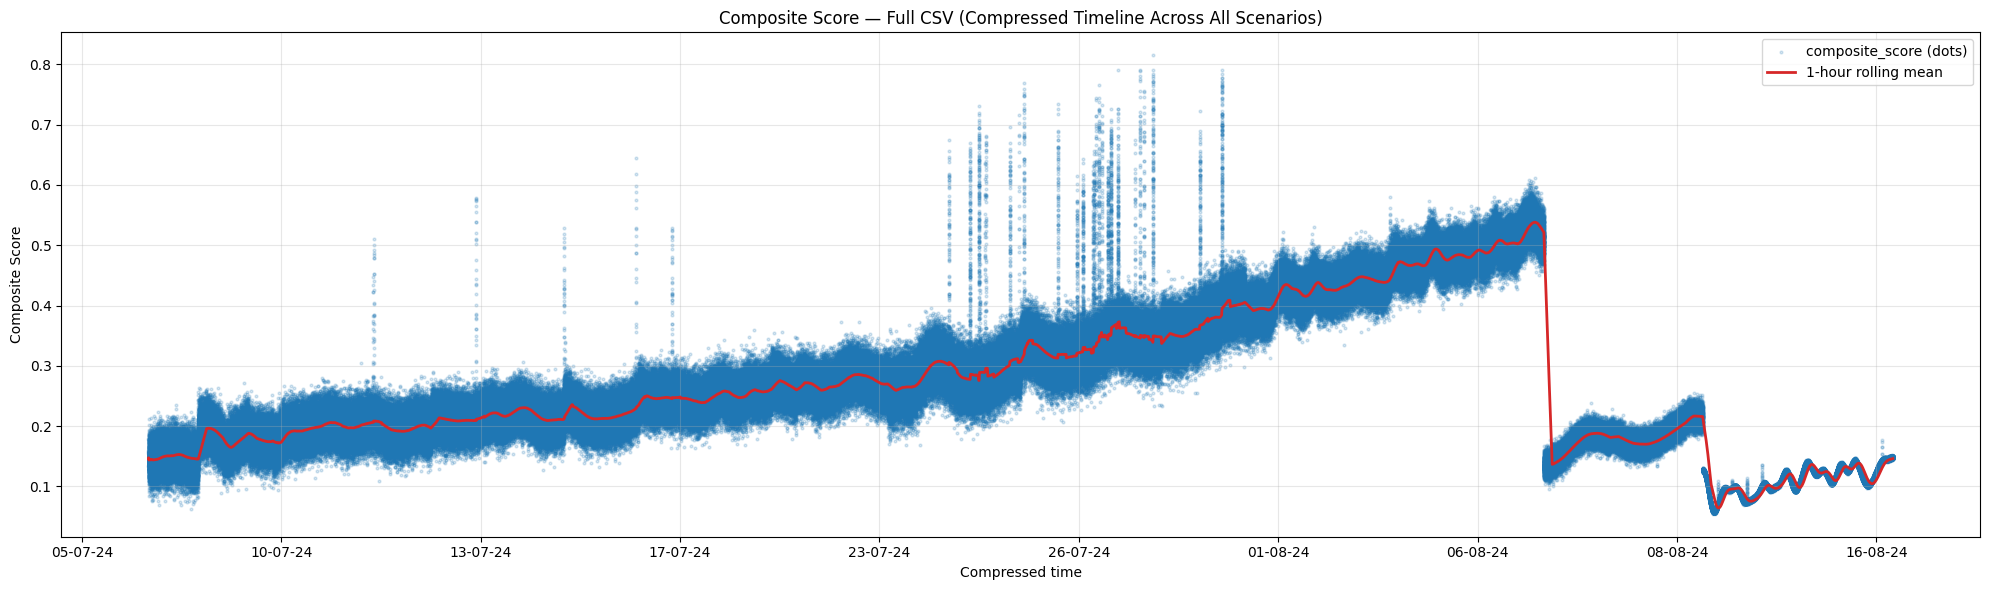

In [3]:
# === Full CSV Compressed Timeline Plot (All Scenarios) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

CSV_PATH = r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv"

# Load only needed columns
df = pd.read_csv(CSV_PATH, usecols=["timestamp", "composite_score"], low_memory=False)
df = df.dropna(subset=["timestamp", "composite_score"]).reset_index(drop=True)
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# Sort by time (safety)
df = df.sort_values("timestamp").reset_index(drop=True)

# === Compress timeline by removing gaps > 30 minutes ===
GAP_MINUTES = 30
gap_thresh = pd.Timedelta(minutes=GAP_MINUTES)

ts = df["timestamp"]
diffs = ts.diff().fillna(pd.Timedelta(seconds=0))
segment_start = diffs > gap_thresh
segment_id = segment_start.cumsum()

# Build cumulative gap-removal shift
shifts = pd.Series(pd.Timedelta(0), index=df.index)
prev_end = ts.iloc[0]
cumulative_shift = pd.Timedelta(0)

for i, (_, g) in enumerate(df.groupby(segment_id)):
    seg_start = g["timestamp"].iloc[0]
    seg_end   = g["timestamp"].iloc[-1]

    if i > 0:
        gap = seg_start - prev_end
        cumulative_shift += gap

    shifts.loc[g.index] = cumulative_shift
    prev_end = seg_end

# Add compressed timestamps
df["shifted_ts"] = df["timestamp"] - shifts.values

# Prepare for resampling
df_shift = df.set_index("shifted_ts").sort_index()

# 1-minute mean for smoothness (kept behavior but changed 'T' -> 'min' to avoid FutureWarning)
resampled = df_shift["composite_score"].resample("0.3min").mean().interpolate()

# 1-hour rolling mean
rolling_1h = resampled.rolling("60min", min_periods=1).mean()

# === Plot (UNCHANGED visuals: compressed timeline used for x) ===
plt.figure(figsize=(20,6))

plt.scatter(df_shift.index,
            df_shift["composite_score"],
            s=4, alpha=0.18, color="tab:blue",
            label="composite_score (dots)")

plt.plot(rolling_1h.index,
         rolling_1h.values,
         color="tab:red", linewidth=2.0,
         label="1-hour rolling mean")

plt.title("Composite Score — Full CSV (Compressed Timeline Across All Scenarios)")
plt.xlabel("Compressed time")
plt.ylabel("Composite Score")
plt.grid(alpha=0.3)
plt.legend()

# === FIX X-AXIS LABELS: show REAL date (dd-mm-yy) for each compressed tick ===
# Build a UNIQUE mapping from shifted_ts -> a representative real timestamp (first occurrence)
# This ensures the index used for nearest lookup is unique (no InvalidIndexError).
real_ts_map = df.groupby("shifted_ts")["timestamp"].first().sort_index()  # DatetimeIndex, unique

def format_real_date(x, pos):
    # x is a Matplotlib float date value corresponding to a shifted_ts
    try:
        shifted_dt = mdates.num2date(x)              # returns a datetime.datetime
        shifted_ts = pd.Timestamp(shifted_dt)       # convert to pandas Timestamp for lookup
        # find nearest shifted index in real_ts_map (unique index so get_indexer works)
        idx = real_ts_map.index.get_indexer([shifted_ts], method="nearest")[0]
        if idx == -1:
            return ""
        real_dt = real_ts_map.iloc[idx]
        return real_dt.strftime("%d-%m-%y")
    except Exception:
        return ""

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_real_date))

plt.tight_layout()
plt.show()
